Try to extract coordinates from tables

In [3]:
%load_ext autoreload
%autoreload 2

import json
import shutil 
from pathlib import Path
from ontology_learner.publication import Publication
from tqdm import tqdm
from llm_query.chat_client import ChatClientFactory
from dotenv import load_dotenv
import os
from ontology_learner.gpt4_direct.gpt_term_mining import (
    mk_batch_script,
    run_batch_request,
    wait_for_batch_completion,
    get_batch_results,
    save_batch_results,
    )
from ontology_learner.json_utils import get_jsonl_file, parse_jsonl_results, load_jsonl
import numpy as np
import pandas as pd
from icecream import ic
import seaborn as sns
import matplotlib.pyplot as plt
from ontology_learner.coordinate_extraction.extraction_utils import get_coord_prompt

load_dotenv()
api_key = os.getenv("OPENAI")

datadir = Path(os.getenv('DATADIR'))
print(datadir)

client = ChatClientFactory.create_client("openai", model="gpt-4o", 
                                         api_key=api_key,
                                         temperature=0)

jsondir = datadir / 'json'





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/poldrack/Dropbox/data/ontology-learner/data


In [4]:
jsonfiles = list(jsondir.glob('*.json'))
pmids = sorted([f.stem for f in jsonfiles])
len(pmids)


132257

In [5]:

if not (datadir / 'coordinate_extraction/tabledata.json').exists():
    tabledata = {}

    for pmid in tqdm(pmids):
        p = Publication(pmid, datadir=jsondir)
        p.parse_sections()
        if 'TABLE' in p.sections and 'coordinate' in p.sections['TABLE'].lower():
            tabledata[pmid] = p.sections['TABLE']

    with open(datadir / 'coordinate_extraction/tabledata.json', 'w') as f:
        json.dump(tabledata, f, indent=4)

else:
    print('loading tabledata from file')
    with open(datadir / 'coordinate_extraction/tabledata.json', 'r') as f:
        tabledata = json.load(f)

print(f'loaded {len(tabledata)} tables')

loading tabledata from file
loaded 14635 tables


In [6]:
def get_processed_pmids(coordinate_mining_dir):
    processed_pmids = []
    for f in coordinate_mining_dir.glob('*.jsonl'):
        json_data = load_jsonl(f)
        for item in json_data:
            processed_pmids.append(item['custom_id'])
    return processed_pmids


coordinate_mining_dir = datadir / 'coordinate_extraction/gpt4_results'
batchfile_dir = datadir / 'coordinate_extraction/gpt4_batchfiles'
coordinate_mining_dir.mkdir(exist_ok=True, parents=True)
batchfile_dir.mkdir(exist_ok=True, parents=True)

processed_pmids = get_processed_pmids(coordinate_mining_dir)
unprocessed_pmids = [pmid for pmid in tabledata.keys() if pmid not in processed_pmids]
print(f'found {len(processed_pmids)} processed pmids and {len(unprocessed_pmids)} unprocessed pmids out of {len(tabledata)} total')


found 14632 processed pmids and 3 unprocessed pmids out of 14635 total


In [7]:

n_papers_to_process = 4500
custom_ids = unprocessed_pmids[:n_papers_to_process]
tabledata_list = [tabledata[pmid] for pmid in custom_ids]
batchfile = datadir / 'coordinate_extraction/gpt4_coordinate_extraction_batch.jsonl'
run_batch = False


if run_batch:
    mk_batch_script(batchfile, tabledata_list, get_coord_prompt, custom_ids=custom_ids, overwrite=True)
    batch_metadata, batch_client = run_batch_request(batchfile, 'coordinate_extraction')

    wait_for_batch_completion(batch_metadata, batch_client)
    batch_results = get_batch_results(batch_client, batch_metadata.id)
    shutil.move(batchfile, batchfile_dir / f'{batch_metadata.id}_cmds.jsonl')
    outfile = save_batch_results(batch_results, batch_metadata.id, coordinate_mining_dir)

In [8]:

coordinate_mining_files = list(coordinate_mining_dir.glob('*.jsonl'))
coord_results = {}
for coordinate_mining_file in coordinate_mining_files:
    coord_results.update(parse_jsonl_results(load_jsonl(coordinate_mining_file)))

print(f'found {len(coord_results)} coordinate results')

with open(datadir / 'coordinate_extraction/coord_results_gpt4.json', 'w') as f:
    json.dump(coord_results, f, indent=4)


found 14168 coordinate results


### Process extracted coordinates

In [9]:
coord_results_clean = {k: v for k, v in coord_results.items() if len(v) > 0}
print(f'found {len(coord_results_clean)} tables with coordinates in {len(coord_results)} tables')



found 13431 tables with coordinates in 14168 tables


In [10]:
# check if the result is a list of dictionaries
result_is_dict = [isinstance(coord_results_clean[k], list) for k in coord_results_clean.keys()]
print(f'{sum(result_is_dict)} results of {len(coord_results_clean)} are lists of dictionaries')

def is_good_coord(coord):
    return 'x' in coord and 'y' in coord and 'z' in coord

all_coords = []
good_coords = []
coords_with_contrast = []
coords_with_cluster_size = []
coords_with_label = []
coords_with_statistic_type = []
coords_with_statistic_value = []
coords_with_coordinate_type = []
coords_list = []

for k, v in coord_results_clean.items():
    for coord_dict in v:
        all_coords.append(coord_dict)
        contrast, x, y, z, cluster_size, label, statistic, coordinate_type = None, None, None, None, None, None, None, None
        if is_good_coord(coord_dict):
            good_coords.append(coord_dict)
            x, y, z = coord_dict['x'], coord_dict['y'], coord_dict['z']
        if 'contrast' in coord_dict and coord_dict['contrast'] is not None:
            contrast = coord_dict['contrast']
            coords_with_contrast.append(coord_dict)
        if 'cluster_size' in coord_dict and coord_dict['cluster_size'] is not None:
            cluster_size = coord_dict['cluster_size']
            coords_with_cluster_size.append(coord_dict)
        if 'label' in coord_dict and coord_dict['label'] is not None:
            label = coord_dict['label']
            coords_with_label.append(coord_dict)
        if 'statistic_type' in coord_dict and coord_dict['statistic_type'] is not None:
            statistic_type = coord_dict['statistic_type']
            coords_with_statistic_type.append(coord_dict)
        if 'statistic_value' in coord_dict and coord_dict['statistic_value'] is not None:
            statistic_value = coord_dict['statistic_value']
            coords_with_statistic_value.append(coord_dict)
        if 'coordinate_type' in coord_dict and coord_dict['coordinate_type'] is not None:
            coordinate_type = coord_dict['coordinate_type']
            coords_with_coordinate_type.append(coord_dict)
        coords_list.append({
            'pmid': k,
            'contrast': contrast,
            'x': x,
            'y': y,
            'z': z,
            'cluster_size': cluster_size,
            'label': label,
            'statistic_type': statistic_type,
            'statistic_value': statistic_value,
            'coordinate_type': coordinate_type
        })

print(f'found {len(good_coords)} good coordinates out of {len(all_coords)} total coordinates')
print(f'found {len(coords_with_contrast)} coordinates with contrast out of {len(all_coords)} total coordinates')
print(f'found {len(coords_with_cluster_size)} coordinates with cluster size out of {len(all_coords)} total coordinates')
print(f'found {len(coords_with_label)} coordinates with label out of {len(all_coords)} total coordinates')
print(f'found {len(coords_with_statistic_type)} coordinates with statistic type out of {len(all_coords)} total coordinates')
print(f'found {len(coords_with_statistic_value)} coordinates with statistic value out of {len(all_coords)} total coordinates')
print(f'found {len(coords_with_coordinate_type)} coordinates with coordinate type out of {len(all_coords)} total coordinates')


13431 results of 13431 are lists of dictionaries
found 289358 good coordinates out of 289358 total coordinates
found 281573 coordinates with contrast out of 289358 total coordinates
found 201620 coordinates with cluster size out of 289358 total coordinates
found 287437 coordinates with label out of 289358 total coordinates
found 243105 coordinates with statistic type out of 289358 total coordinates
found 243543 coordinates with statistic value out of 289358 total coordinates
found 275777 coordinates with coordinate type out of 289358 total coordinates


### convert to a single coordinate list

In [11]:
coords_df = pd.DataFrame(coords_list)
# fix the pmid column
coords_df['pmcid'] = coords_df['pmid'].astype(str)

# add a pmid column
pmcid_to_pmid = json.load(open(datadir / 'pmcid_to_pmid.json', 'r'))
coords_df['pmid'] = coords_df['pmcid'].map(pmcid_to_pmid)
coords_df.head()

,pmid,contrast,x,y,z,cluster_size,label,statistic_type,statistic_value,coordinate_type,pmcid
0,21982930,Delta+ high TAS > Delta+ low TAS,-18.0,-61.0,41.0,8064,precuneus,F,15.32,None,3256346
1,21982930,Delta+ high TAS > Delta+ low TAS,-48.0,-44.0,-3.0,3968,middle temporal gyrus,F,13.76,None,3256346
2,21982930,Delta+ high TAS > Delta+ low TAS,-37.0,-10.0,-6.0,3904,insula,F,15.26,None,3256346
3,21982930,Delta+ high TAS > Delta+ low TAS,-36.0,36.0,3.0,3776,inferior frontal gyrus,F,9.8,None,3256346
4,21982930,Delta+ high TAS > Delta+ low TAS,53.0,-47.0,-4.0,2880,middle temporal gyrus,F,17.52,None,3256346


In [12]:
full_length = len(coords_df)
# remove rows with missing x/y/z coords
coords_df = coords_df[coords_df['x'].notna() & coords_df['y'].notna() & coords_df['z'].notna()]

# remove rows with x/y/z as lists
coords_df = coords_df[~coords_df['x'].apply(lambda x: isinstance(x, list))]

# remove rows with x/y/z values that are not numbers
coords_df = coords_df[coords_df['x'].apply(lambda x: isinstance(x, (int, float)))]
coords_df = coords_df[coords_df['y'].apply(lambda x: isinstance(x, (int, float)))]
coords_df = coords_df[coords_df['z'].apply(lambda x: isinstance(x, (int, float)))]

# remove rows with x/y/z values that are outside of the range of -200 to 200
coords_df = coords_df[coords_df['x'].apply(lambda x: x >= -200 and x <= 200)]
coords_df = coords_df[coords_df['y'].apply(lambda x: x >= -200 and x <= 200)]
coords_df = coords_df[coords_df['z'].apply(lambda x: x >= -200 and x <= 200)]


print(f'cleaup removed {full_length - len(coords_df)} rows out of {full_length} ({len(coords_df)} rows remaining)')

coords_df.to_csv(datadir / 'coordinate_extraction/coords_df_gpt4.csv', index=False)

cleaup removed 740 rows out of 289358 (288618 rows remaining)


In [24]:
# how many have cluster size
print(f'{len(coords_df[coords_df["cluster_size"].notna()])} rows with cluster size')

# how many have coordinate type
print(f'{len(coords_df[coords_df["coordinate_type"].notna()])} rows with coordinate type')

# how many have statistic
print(f'{len(coords_df[coords_df["statistic_type"].notna()])} rows with statistic_type')
print(f'{len(coords_df[coords_df["statistic_value"].notna()])} rows with statistic_value')
# how many have label
print(f'{len(coords_df[coords_df["label"].notna()])} rows with label')


201396 rows with cluster size
275374 rows with coordinate type
288618 rows with statistic_type
288618 rows with statistic_value
286733 rows with label


In [25]:
coords_df.statistic_type.value_counts()

statistic_type
t                      109379
Z                       69405
T                       36551
z                       19320
F                       13283
                        ...  
1-P                         1
Value not specified         1
TFCE Value                  1
Maximum ALE score           1
conjunction                 1
Name: count, Length: 591, dtype: int64

In [26]:
print(coords_df.coordinate_type.value_counts())




coordinate_type
MNI                  218469
Talairach             45637
Unknown                1974
unknown                1622
Not specified           895
                      ...  
Brodmann areas 32         1
SPM99(MNI)                1
MNISPM99                  1
MNI 305                   1
Brodmann areas 11         1
Name: count, Length: 192, dtype: int64


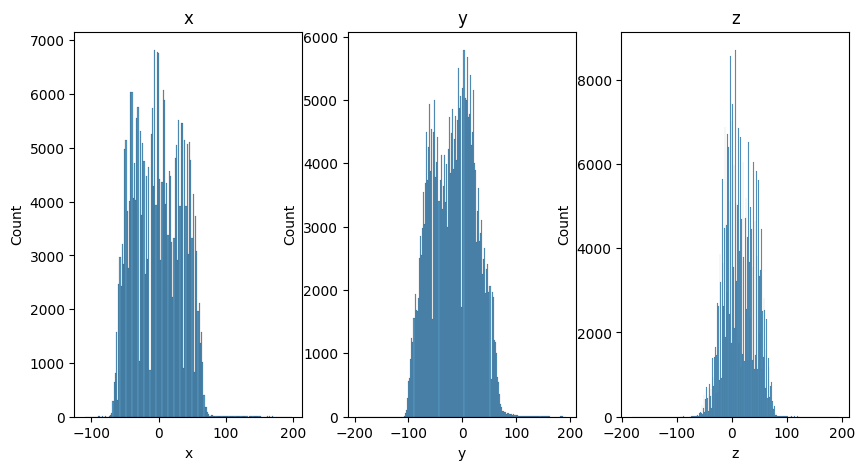

In [27]:
# plot x/y/z distributions as subplots in a single figure
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
sns.histplot(data=coords_df, x='x', ax=axs[0])
axs[0].set_title('x')
sns.histplot(data=coords_df, x='y', ax=axs[1])
axs[1].set_title('y')
sns.histplot(data=coords_df, x='z', ax=axs[2])
axs[2].set_title('z')
plt.show()




[[-7, 9]]

In [164]:
coords_df

,pmid,contrast,x,y,z,cluster_size,label,statistic,coordinate_type
0,7563784,TEA vs. TGA,-30,-30,-25,None,Parahippocampal gyrus (l),"{'t': 2.62, 'p': 0.499}",MNI
1,7563784,TEA vs. TGA,-20,-20,-20,None,Parahippocampal gyrus (l),"{'t': 3.05, 'p': 0.278}",MNI
2,7563784,TEA vs. TGA,-30,-5,-40,None,Uncus (l),"{'t': 3.83, 'p': 0.08}",MNI
3,7563784,TEA vs. TGA,-25,-5,-25,None,Uncus (l),"{'t': 3.83, 'p': 0.08}",MNI
4,7563784,TEA vs. TGA,-25,-20,-30,None,Parahippocampal gyrus (l),"{'t': 4.2, 'p': 0.042}",MNI
...,...,...,...,...,...,...,...,...,...
226849,3400659,Regions displaying greater activation during r...,18,-82,54,1405,"Lateral occipital cortex, supramarginal gyrus,...",3.63,MNI
226850,3400659,Regions displaying greater activation during r...,48,26,10,1112,"Inferior frontal gyrus, middle frontal gyrus, ...",3.67,MNI
226851,3400659,Regions displaying greater activation during r...,-48,14,4,939,"Inferior frontal gyrus, orbitofrontal cortex, ...",4.12,MNI
226852,3400659,Regions displaying greater activation during r...,6,38,42,815,"Superior frontal gyrus, supplementary motor co...",3.44,MNI
